## 1、导入必要的库，加载数据

In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 加载数据集
X_train = pd.read_csv('breast_cancer_Xtrain.csv', header=None)
X_test = pd.read_csv('breast_cancer_Xtest.csv', header=None)
y_train = pd.read_csv('breast_cancer_Ytrain.csv', header=None)
y_test = pd.read_csv('breast_cancer_Ytest.csv', header=None)

# 确保标签是1维数组
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


## 2、实现四个示例性的SVM模型

In [4]:
# 定义和训练SVM模型
models = {
    "Linear SVM (C=1)": SVC(kernel='linear', C=1),
    "Linear SVM (C=1000)": SVC(kernel='linear', C=1000),
    "Polynomial SVM (C=1, d=2)": SVC(kernel='poly', C=1, degree=2),
    "Polynomial SVM (C=1000, d=2)": SVC(kernel='poly', C=1000, degree=2)
}

# 训练并评估模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")


Linear SVM (C=1) Accuracy: 0.9825
Linear SVM (C=1000) Accuracy: 0.9561
Polynomial SVM (C=1, d=2) Accuracy: 0.9825
Polynomial SVM (C=1000, d=2) Accuracy: 0.9386


## 3、定义Laplacian核函数

In [5]:
def laplacian_kernel(X, Y, gamma):
    K = np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2))
    return K

## 4、定义自定义SVC类

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.multiclass import unique_labels

class CustomSVC(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, laplacian_gamma=1.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.laplacian_gamma = laplacian_gamma
        self.svc = SVC(C=self.C, kernel=self.kernel, degree=self.degree, gamma=self.gamma, coef0=self.coef0)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.kernel == 'laplacian':
            self.svc.kernel = lambda X, Y: laplacian_kernel(X, Y, self.laplacian_gamma)
        self.svc.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        X = check_array(X)
        return self.svc.predict(X)

## 5、设置参数网格并进行网格搜索

In [7]:
param_grid = {
    'C': [10**-3, 10**-2, 10**-1, 1, 10, 10**2, 10**3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'laplacian'],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'laplacian_gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(CustomSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

Best Parameters: {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear', 'laplacian_gamma': 0.001}
Best Cross-Validation Accuracy: 0.9780


## 6、在测试集上评估最优模型

In [8]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_test_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Model Test Accuracy: {best_test_accuracy:.4f}")

Best Model Test Accuracy: 0.9825


## 7、对测试集中所有数据进行预测并输出结果

In [9]:
y_pred_all = best_model.predict(X_test)

# 计算所有测试数据的准确率
test_accuracy = accuracy_score(y_test, y_pred_all)
print(f"Test Accuracy: {test_accuracy:.4f}")

# 将预测结果转换为 DataFrame
result_df = pd.DataFrame(y_pred_all)

# 将结果保存到 result2.csv 文件中，没有表头，只有一列数据标签分类
result_df.to_csv('result2.csv', index=False, header=False)


Test Accuracy: 0.9825


## 8、找出不同的标签

In [10]:
import pandas as pd

# 加载原始标签和预测标签
original_labels = pd.read_csv('breast_cancer_Ytest.csv', header=None).values.ravel()
predicted_labels = pd.read_csv('result2.csv', header=None).values.ravel()

# 创建 DataFrame 来存储比较结果
comparison_df = pd.DataFrame({
    'Original': original_labels,
    'Predicted': predicted_labels
})

# 找出不同的标签
differences = comparison_df[comparison_df['Original'] != comparison_df['Predicted']]

# 输出不同标签的行数
print(f"Number of differences: {len(differences)}")

# 输出所有不同的标签
print("Differences between original and predicted labels:")
print(differences)


Number of differences: 2
Differences between original and predicted labels:
    Original  Predicted
20         1         -1
77         1         -1


## 可视化分类效果

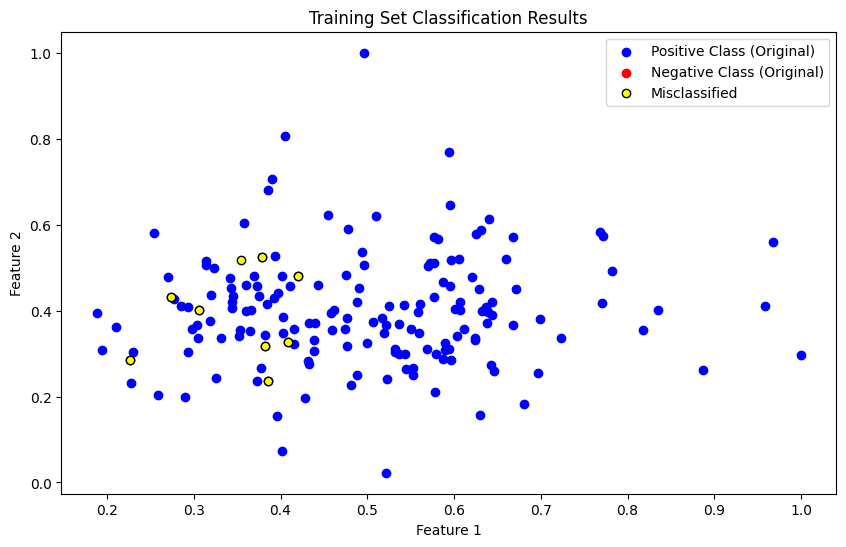

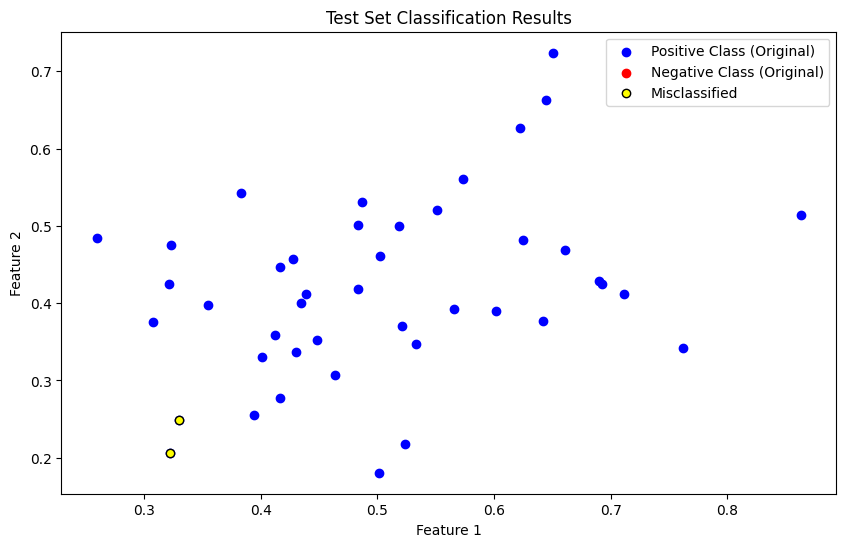

In [11]:
# 可视化分类效果
def plot_classification_results(X, y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    
    # 正类样本
    plt.scatter(X[y_true == 1][:, 0], X[y_true == 1][:, 1], color='blue', label='Positive Class (Original)')
    
    # 负类样本
    plt.scatter(X[y_true == 0][:, 0], X[y_true == 0][:, 1], color='red', label='Negative Class (Original)')
    
    # 误分类样本
    plt.scatter(X[y_true != y_pred][:, 0], X[y_true != y_pred][:, 1], color='yellow', edgecolor='black', label='Misclassified')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_classification_results(X_train.values[:, :2], y_train, best_model.predict(X_train.values), 'Training Set Classification Results')
plot_classification_results(X_test.values[:, :2], y_test, y_pred_all, 'Test Set Classification Results')

## 完整的code

Linear SVM (C=1) Accuracy: 0.9825
Linear SVM (C=1000) Accuracy: 0.9561
Polynomial SVM (C=1, d=2) Accuracy: 0.9825
Polynomial SVM (C=1000, d=2) Accuracy: 0.9386
Best Parameters: {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear', 'laplacian_gamma': 0.001}
Best Cross-Validation Accuracy: 0.9780
Best Model Test Accuracy: 0.9825
Test Accuracy: 0.9825
Number of differences: 2
Differences between original and predicted labels:
    Original  Predicted
20         1         -1
77         1         -1


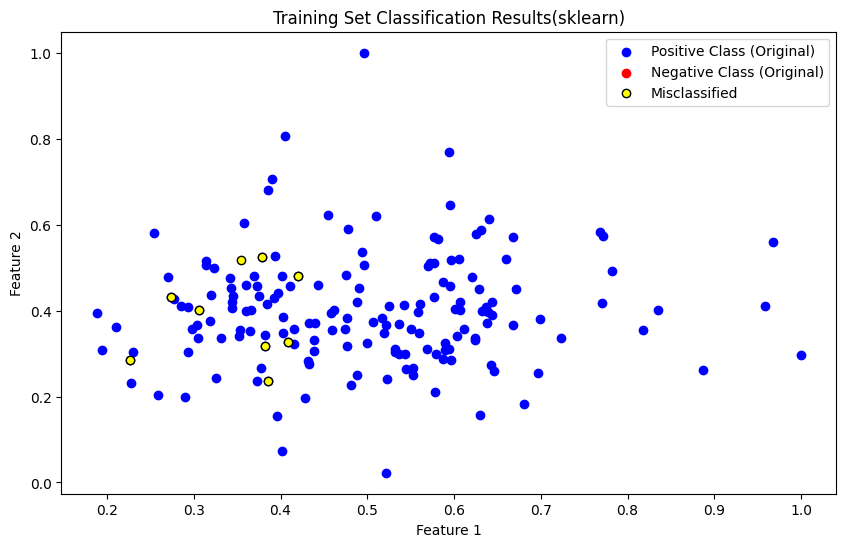

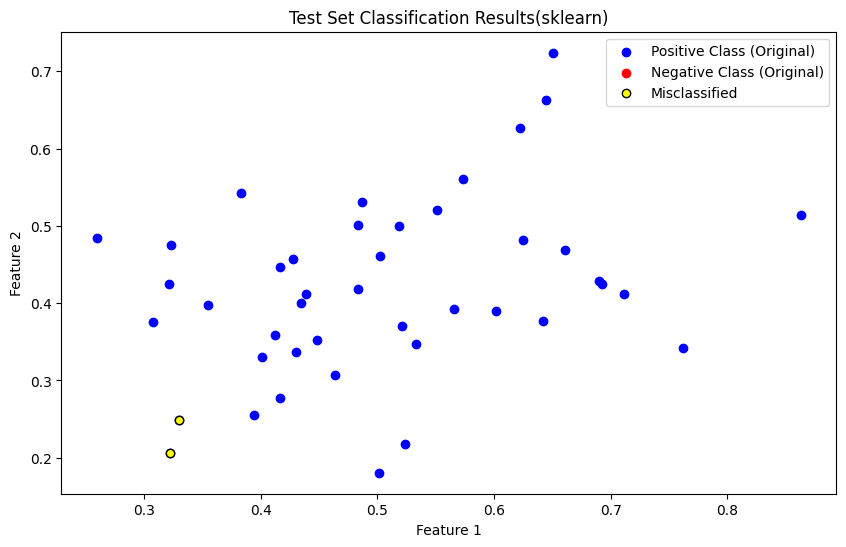

In [12]:
# 1. 导入必要的库和加载数据集
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 加载数据
X_train = pd.read_csv('breast_cancer_Xtrain.csv', header=None)
X_test = pd.read_csv('breast_cancer_Xtest.csv', header=None)
y_train = pd.read_csv('breast_cancer_Ytrain.csv', header=None)
y_test = pd.read_csv('breast_cancer_Ytest.csv', header=None)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# 2. 实现四个示例性的SVM模型
# 定义和训练SVM模型
models = {
    "Linear SVM (C=1)": SVC(kernel='linear', C=1),
    "Linear SVM (C=1000)": SVC(kernel='linear', C=1000),
    "Polynomial SVM (C=1, d=2)": SVC(kernel='poly', C=1, degree=2),
    "Polynomial SVM (C=1000, d=2)": SVC(kernel='poly', C=1000, degree=2)
}

# 训练并评估模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# 3. 定义拉普拉斯核函数
def laplacian_kernel(X, Y, gamma):
    K = np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2))
    return K

# 4. 定义自定义SVC类
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.multiclass import unique_labels

class CustomSVC(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, laplacian_gamma=1.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.laplacian_gamma = laplacian_gamma
        self.svc = SVC(C=self.C, kernel=self.kernel, degree=self.degree, gamma=self.gamma, coef0=self.coef0)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.kernel == 'laplacian':
            self.svc.kernel = lambda X, Y: laplacian_kernel(X, Y, self.laplacian_gamma)
        self.svc.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        X = check_array(X)
        return self.svc.predict(X)

# 5. 设置参数网格并进行网格搜索
param_grid = {
    'C': [10**-3, 10**-2, 10**-1, 1, 10, 10**2, 10**3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'laplacian'],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'laplacian_gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(CustomSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# 6. 在测试集上评估最优模型
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_test_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Model Test Accuracy: {best_test_accuracy:.4f}")

# 7. 对测试集中所有数据进行预测并输出结果
y_pred_all = best_model.predict(X_test)

# 计算所有测试数据的准确率
test_accuracy = accuracy_score(y_test, y_pred_all)
print(f"Test Accuracy: {test_accuracy:.4f}")

# 将预测结果转换为 DataFrame
result_df = pd.DataFrame(y_pred_all)

# 将结果保存到 result2.csv 文件中，没有表头，只有一列数据标签分类
result_df.to_csv('result2.csv', index=False, header=False)

# 8. 找出不同的标签
# 加载原始标签和预测标签
original_labels = pd.read_csv('breast_cancer_Ytest.csv', header=None).values.ravel()
predicted_labels = pd.read_csv('result2.csv', header=None).values.ravel()

# 创建 DataFrame 来存储比较结果
comparison_df = pd.DataFrame({
    'Original': original_labels,
    'Predicted': predicted_labels
})

# 找出不同的标签
differences = comparison_df[comparison_df['Original'] != comparison_df['Predicted']]

# 输出不同标签的行数
print(f"Number of differences: {len(differences)}")

# 输出所有不同的标签
print("Differences between original and predicted labels:")
print(differences)

# 可视化分类效果
def plot_classification_results(X, y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    
    # 正类样本
    plt.scatter(X[y_true == 1][:, 0], X[y_true == 1][:, 1], color='blue', label='Positive Class (Original)')
    
    # 负类样本
    plt.scatter(X[y_true == 0][:, 0], X[y_true == 0][:, 1], color='red', label='Negative Class (Original)')
    
    # 误分类样本
    plt.scatter(X[y_true != y_pred][:, 0], X[y_true != y_pred][:, 1], color='yellow', edgecolor='black', label='Misclassified')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_classification_results(X_train.values[:, :2], y_train, best_model.predict(X_train.values), 'Training Set Classification Results(sklearn)')
plot_classification_results(X_test.values[:, :2], y_test, y_pred_all, 'Test Set Classification Results(sklearn)')
